# Feed-Forward Neural Network.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List
import pickle # To store data and trained models
from tqdm import tqdm # To visualize progress bars during training

We need to train and test the network using the MNIST_784 dataset. We also know that MNIST is a dataset consisting of 70000 grayscale images of handwritten digits. I have downloaded MNIST as a python dictionary (using e.g. scikit-learn) as below and have stored the dataset itself in data and the target in labels.

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml(name="mnist_784")

In [3]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
data = mnist.data
labels = mnist.target

In [5]:
# labels.shape

### Activation Functions
An activation function in a neural network defines how the weighted sum of the input is transformed into an output from a node or nodes in a layer of the network.
The activation function is used within or after the internal processing of each node in the network, although networks are designed to use the same activation function for all nodes in a layer.
A network may have three types of layers: input layers that take raw input from the domain, hidden layers that take input from another layer and pass output to another layer, and output layers that make a prediction.
All hidden layers typically use the same activation function. The output layer will typically use a different activation function from the hidden layers and is dependent upon the type of prediction required by the model.


### Activation For Hidden Layers 
A hidden layer in a neural network is a layer that receives input from another layer (such as another hidden layer or an input layer) and provides output to another layer (such as another hidden layer or an output layer). A neural network may have zero or more hidden layers.
Certain activation functions that one may want to consider for use in hidden layers; they are:<br>
 -  Rectified Linear Activation (ReLU)<br>
 -  Logistic (Sigmoid)<br>
 -  Hyperbolic Tangent (Tanh)<br>
### Activation Function For Output Layers
The output layer is the layer in a neural network model that directly outputs a prediction. All feed-forward neural network models have an output layer.
Certain activation functions one may want to consider for use in the output layer; they are:<br>
 - Linear<br>
 - Logistic (Sigmoid)<br>
 - Softmax<br>


In [6]:
def tanh(z: np.ndarray) -> np.ndarray:
    return np.tanh(z)
def relu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z)

## For the final layer I have used softmax given that this is a multiclass classification problem.
def softmax(z: np.ndarray) -> np.ndarray:
    e = np.exp(z - np.max(z))
    return e / np.sum(e, axis=0, keepdims=True)

def activation_function(function_name: str, z: np.ndarray) -> np.ndarray:
    if function_name == "tanh":
        return 1 - np.square(tanh(z))
    if function_name == "relu":
        y = (z > 0) * 1
        return y
    return "No such activation"

Before training our network, we are going to need some preprocessing functions:<br>
 1. a normalize function to scale the inputs to the [0, 1] range and<br>
 2. a one-hot-encode function, which will turn the array of labels from an n-sized vector (where n is the number of samples to an n x m array (where m is the number of possible outputs).
There are various ways of scaling features: in this case, I have used min-max scaling (one can also just divide each feature by the number of the possible values a feature can take — in this case, 255):

In [7]:
def normalize(x: np.ndarray) -> np.ndarray:
    return (x - np.min(x)) / (np.max(x) - np.min(x))
def one_hot_encode(x: np.ndarray, num_labels: int) -> np.ndarray:
    return np.eye(num_labels)[x]

## Implementing the neural network
I have implemented the neural netowrk as a class which has the following methods:<br>

 - an init method
 - a feed - forward propagation method
 - implementing backpropagation
 - training the network
 - computing the cost function
 - methods to predict
 - computing accuracy and potting the same<br>

I have passed the following arguments to the constructor:<br>
 - the training set with the corresponding labels
 - the test set with its labels
 - an activation function choice (as a string)
 - the number of classes we need to predict
 - the architecture — which we represent as a list, where each element of the list corresponds to a deep layer and indicates the number of neurons in that layer.<br>
 
Then I have used a dictionary to store the layers, and named them with strings in order to keep a track of the layers

In [8]:
class NN(object):
    def __init__(self, X: np.ndarray, y: np.ndarray, X_test: np.ndarray, y_test: np.ndarray, activation: str, num_labels: int, architecture: List[int]):
        self.X = normalize(X) # normalize training data in range 0,1
        ## Assertions are simply boolean expressions that check if the conditions return true or not
        assert np.all((self.X >= 0) | (self.X <= 1)) # test that normalize succeded
        self.X, self.X_test = X.copy(), X_test.copy()
        self.y, self.y_test = y.copy(), y_test.copy()
        self.layers = {} # define dictionary to store results of activation
        self.architecture = architecture # size of hidden layers as array  
        self.activation = activation # activation function
        assert self.activation in ["relu", "tanh"]
        self.parameters = {}
        self.num_labels = num_labels
        self.m = X.shape[1]
        ## it adds a layer with size m where m is the number of features at the beginning of the architecture list 
        self.architecture.append(self.num_labels)
        self.num_input_features = X.shape[0]
        ## adding another layer with size n (the number of classes) at the end
        self.architecture.insert(0, self.num_input_features)
        self.L = len(architecture) 
        assert self.X.shape == (self.num_input_features, self.m)
        assert self.y.shape == (self.num_labels, self.m)
        
    def initialize_parameters(self):
        # iterate over the number of deep layers (starting at 1 and ending at L-1, where L is the length of the architecture list)
        # storing each weight matrix in the dictionary using the key w{i} and each bias vector with key b{i}.
        for i in range(1, self.L):
            print(f"Initializing parameters for layer: {i}.")
            # initialize the weights by randomly picking them from a normally distributed sample and scaling them by a factor of 100
            self.parameters["w"+str(i)] = np.random.randn(self.architecture[i], self.architecture[i-1]) * 0.01
            # the biases are a vector of zeros: one for each node in the layer.
            self.parameters["b"+str(i)] = np.zeros((self.architecture[i], 1))
    
    # For each node in each of the layers except the input and outputs layer, an input (the weighted sum of inputs) and an activation output is required. 
    # Storing the same in layers dictionary as z{i} and a{i} respectively for each of the i deep layers in the model’s architecture.
    def feed_forward(self):
        params=self.parameters
        self.layers["a0"] = self.X
        #  iterate over the range (1, length of the architecture-1)
        for l in range(1, self.L-1):
            # to obtain layers[zi] for each i in that range calculate the dot product of parameters[wi] and layers[a-i] and add parameters[bi]
            self.layers["z" + str(l)] = np.dot(params["w" + str(l)],self.layers["a"+str(l-1)]) + params["b"+str(l)]
            # to obtain the activation output layers[ai], apply the activation function of choice to layers[zi]
            self.layers["a" + str(l)] = eval(self.activation)(self.layers["z"+str(l)])
            # assert self.layers["a"+str(l)].shape == (self.architecture[l], self.m)
        # Storing result of the 2nd last layer  and using softmax activation for multiclass classification
        self.layers["z" + str(self.L-1)] = np.dot(params["w" + str(self.L-1)],self.layers["a"+str(self.L-2)]) + params["b"+str(self.L-1)]
        self.layers["a"+str(self.L-1)] = softmax(self.layers["z"+str(self.L-1)])
        # Classificaion Result of the final layer or output layer
        self.output = self.layers["a"+str(self.L-1)]
        
        assert self.output.shape == (self.num_labels, self.m)
        assert all([s for s in np.sum(self.output, axis=1)])        
        # Calculating cost function using negative log-likelihood
        # cost = np.sum((self.y - self.output)**2)
        cost = - np.sum(self.y * np.log(self.output + 0.000000001))

        return cost, self.layers

    # Backpropagation
    def backpropagate(self):
        #  initialize an empty derivatives dictionary to store the gradients and iterate over the layers from right to left
        derivatives = {}
        # For the outmost layer, dz is simply the result of output — ground truths
        dZ = self.output - self.y
        # assert dZ.shape == (self.num_labels, self.m)# Checking if the shape of the computed output layer matches
        # There are as many rows as there are labels and as many columns as there are training examples.
        # Transpose it to compute teh dot product of dz with the values stored in layers
        dW = np.dot(dZ, self.layers["a" + str(self.L-2)].T) / self.m
        db = np.sum(dZ, axis=1, keepdims=True) / self.m
        dAPrev = np.dot(self.parameters["w" + str(self.L-1)].T, dZ)
        # Updating the weights and biases, respectively for the 2nd last layer
        derivatives["dW" + str(self.L-1)] = dW
        derivatives["db" + str(self.L-1)] = db
        
        for l in range(self.L-2, 0, -1):
            # For each layer, compute dZ and use it to calculate that layer’s dW and dB 
            dZ = dAPrev * activation_function(self.activation, self.layers["z" + str(l)]) 
            # the gradients for the weights are the dot product of dz and the transpose of the activation from the previous layer 
            dW = 1. / self.m * np.dot(dZ, self.layers["a" + str(l-1)].T)
            # the gradients for the biases are just the averaged dz 
            # (keepdims=True or else the array will be squished to shape (1, ) as a rank-1 array which might lead to ambiguous results
            db = 1. / self.m * np.sum(dZ, axis=1, keepdims=True)
            if l > 1:
                # storing the gradients for that layer’s activation in a variable dAPrev
                dAPrev = np.dot(self.parameters["w" + str(l)].T, (dZ))
            # Updating the weights and biases, respectively
            derivatives["dW" + str(l)] = dW
            derivatives["db" + str(l)] = db 
        
        # return the derivatives dictionary defined initially
        self.derivatives = derivatives
        
        return self.derivatives

    
    # Putting it all together to train the network. Pass a learning rate and a number of epochs to the fit method.
    def fit(self, lr, epochs):
        self.costs = [] 
        # train the model by calling initialize_parameters
        self.initialize_parameters()
        # Storing the list of training and testing accuracies in a dictionary
        self.accuracies = {"train": [], "test": []}
        for epoch in tqdm(range(epochs), colour="BLUE"):
            cost, final_layer = self.feed_forward()
            self.costs.append(cost)
            derivatives = self.backpropagate()            
            for layer in range(1, self.L):
                self.parameters["w"+str(layer)] = self.parameters["w"+str(layer)] - lr * derivatives["dW" + str(layer)]
                self.parameters["b"+str(layer)] = self.parameters["b"+str(layer)] - lr * derivatives["db" + str(layer)]            
            train_accuracy = self.accuracy(self.X, self.y)
            test_accuracy = self.accuracy(self.X_test, self.y_test)
            # Displaying the Performance on the training and test sets 
            if epoch % 10 == 0:
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Training Accuracy: {train_accuracy:.3f}")
                print(f"Epoch: {epoch:3d} | Cost: {cost:.3f} | Testing Accuracy: {test_accuracy:.3f}")
            self.accuracies["train"].append(train_accuracy)
            self.accuracies["test"].append(test_accuracy)
        print("Training terminated")

    # Predicting the class of final output layer
    def predict(self, x):
        params = self.parameters
        n_layers = self.L - 1
        values = [x]
        for l in range(1, n_layers):
            z = np.dot(params["w" + str(l)], values[l-1]) + params["b" + str(l)]
            a = eval(self.activation)(z)
            values.append(a)
        z = np.dot(params["w"+str(n_layers)], values[n_layers-1]) + params["b"+str(n_layers)]
        a = softmax(z)
        if x.shape[1]>1:
            ans = np.argmax(a, axis=0)
        else:
            ans = np.argmax(a)
        return ans
    
    # Finding the accuracy 
    def accuracy(self, X, y):
        P = self.predict(X)
        return sum(np.equal(P, np.argmax(y, axis=0))) / y.shape[1]*100
    
    # Plotting the cost values
    def plot_cost(self, lr):
        plt.figure(figsize=(8, 4))
        plt.plot(np.arange(0, len(self.costs)), self.costs, lw=1, color="orange")
        plt.title(f"Learning rate: {lr}\nFinal Cost: {self.costs[-1]:.5f}", fontdict={"family":"sans-serif","size": "12"})
        plt.xlabel("Epoch")
        plt.ylabel("Cost")
        plt.show()
    
    # Plotting the training and testing accuracies
    def plot_accuracies(self, lr):
        acc = self.accuracies
        fig = plt.figure(figsize=(6,4))
        ax = fig.add_subplot(111)
        ax.plot(acc["train"], label="train")
        ax.plot(acc["test"], label="test")
        plt.legend(loc="lower right")
        ax.set_title("Accuracy")
        ax.annotate(f"Train: {acc['train'][-1]:.2f}", (len(acc["train"])+4, acc["train"][-1]+2), color="blue")
        ax.annotate(f"Test: {acc['test'][-1]:.2f}", (len(acc["test"])+4, acc["test"][-1]-2), color="orange")
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        plt.show()

In [9]:
train_test_split_no = 56000
X_train = data.values[:train_test_split_no].T
y_train = labels[:train_test_split_no].values.astype(int)
y_train = one_hot_encode(y_train, 10).T
X_test = data.values[train_test_split_no:].T
y_test = labels[train_test_split_no:].values.astype(int)
y_test = one_hot_encode(y_test, 10).T
X_train.shape, X_test.shape

((784, 56000), (784, 14000))

In [10]:
PARAMS = [X_train, y_train, X_test, y_test, "relu", 10, [512, 300]]

In [11]:
nn_relu = NN(*PARAMS)
epochs_relu = 50
lr_relu = 0.003

In [12]:
nn_relu.fit(lr=lr_relu, epochs=epochs_relu)

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  2%|▏         | 1/50 [00:05<04:51,  5.95s/it]

Epoch:   0 | Cost: 133605.760 | Training Accuracy: 22.804
Epoch:   0 | Cost: 133605.760 | Testing Accuracy: 23.243


 22%|██▏       | 11/50 [01:04<03:47,  5.82s/it]

Epoch:  10 | Cost: 70041.995 | Training Accuracy: 75.591
Epoch:  10 | Cost: 70041.995 | Testing Accuracy: 77.579


 42%|████▏     | 21/50 [02:09<02:52,  5.94s/it]

Epoch:  20 | Cost: 43841.438 | Training Accuracy: 82.454
Epoch:  20 | Cost: 43841.438 | Testing Accuracy: 84.300


 62%|██████▏   | 31/50 [03:08<01:52,  5.93s/it]

Epoch:  30 | Cost: 33677.899 | Training Accuracy: 85.305
Epoch:  30 | Cost: 33677.899 | Testing Accuracy: 87.057


 82%|████████▏ | 41/50 [04:08<00:54,  6.03s/it]

Epoch:  40 | Cost: 28630.236 | Training Accuracy: 86.875
Epoch:  40 | Cost: 28630.236 | Testing Accuracy: 88.643


100%|██████████| 50/50 [05:00<00:00,  6.02s/it]

Training terminated


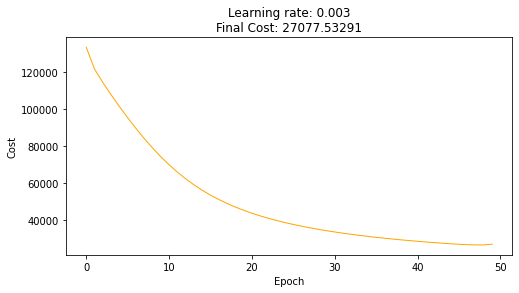

In [13]:
nn_relu.plot_cost(lr_relu)

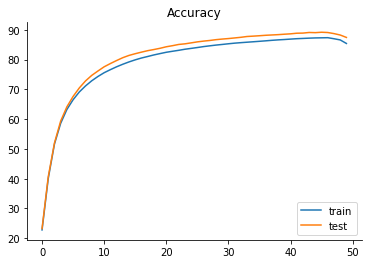

In [14]:
nn_relu.plot_accuracies(lr_relu)

In [15]:
PARAMS = [X_train, y_train, X_test, y_test, "tanh", 10, [512, 300]]
nn_tanh = NN(*PARAMS)
epochs_tanh = 100
lr_tanh = 0.003

In [16]:
nn_tanh.fit(lr=lr_tanh, epochs=epochs_tanh)

Initializing parameters for layer: 1.
Initializing parameters for layer: 2.
Initializing parameters for layer: 3.


  1%|          | 1/100 [00:10<17:45, 10.76s/it]

Epoch:   0 | Cost: 129100.337 | Training Accuracy: 10.573
Epoch:   0 | Cost: 129100.337 | Testing Accuracy: 10.643


 11%|█         | 11/100 [01:25<11:00,  7.42s/it]

Epoch:  10 | Cost: 128334.455 | Training Accuracy: 20.982
Epoch:  10 | Cost: 128334.455 | Testing Accuracy: 20.921


 21%|██        | 21/100 [02:40<09:59,  7.59s/it]

Epoch:  20 | Cost: 127568.080 | Training Accuracy: 31.977
Epoch:  20 | Cost: 127568.080 | Testing Accuracy: 31.807


 31%|███       | 31/100 [03:55<08:32,  7.43s/it]

Epoch:  30 | Cost: 126791.770 | Training Accuracy: 41.389
Epoch:  30 | Cost: 126791.770 | Testing Accuracy: 41.771


 41%|████      | 41/100 [05:06<06:59,  7.11s/it]

Epoch:  40 | Cost: 125997.293 | Training Accuracy: 48.679
Epoch:  40 | Cost: 125997.293 | Testing Accuracy: 49.200


 51%|█████     | 51/100 [06:21<05:58,  7.31s/it]

Epoch:  50 | Cost: 125179.378 | Training Accuracy: 53.802
Epoch:  50 | Cost: 125179.378 | Testing Accuracy: 54.221


 61%|██████    | 61/100 [07:31<04:32,  7.00s/it]

Epoch:  60 | Cost: 124334.527 | Training Accuracy: 57.514
Epoch:  60 | Cost: 124334.527 | Testing Accuracy: 58.057


 71%|███████   | 71/100 [08:42<03:24,  7.05s/it]

Epoch:  70 | Cost: 123455.063 | Training Accuracy: 60.332
Epoch:  70 | Cost: 123455.063 | Testing Accuracy: 61.000


 81%|████████  | 81/100 [09:53<02:12,  6.95s/it]

Epoch:  80 | Cost: 122533.820 | Training Accuracy: 62.314
Epoch:  80 | Cost: 122533.820 | Testing Accuracy: 63.214


 91%|█████████ | 91/100 [11:02<01:02,  6.95s/it]

Epoch:  90 | Cost: 121567.833 | Training Accuracy: 63.948
Epoch:  90 | Cost: 121567.833 | Testing Accuracy: 65.179


100%|██████████| 100/100 [12:05<00:00,  7.25s/it]

Training terminated


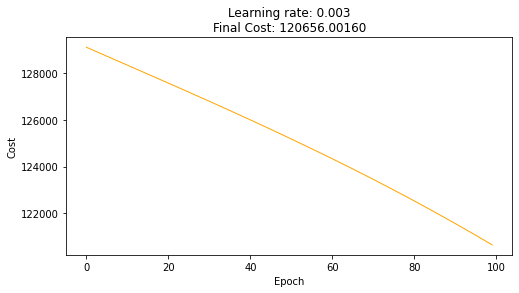

In [17]:
nn_tanh.plot_cost(lr_tanh)

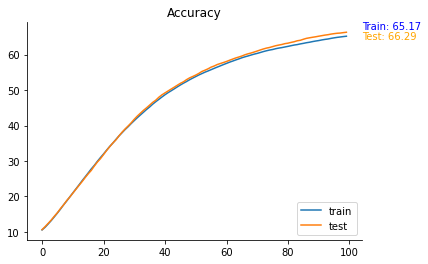

In [18]:
nn_tanh.plot_accuracies(lr_tanh)